In [1]:
import math
from torch.autograd import Variable
from voice_impersonation_utils import *
from voice_impersonation_model import *

In [2]:
input_files = "voice_impersonation_input/"
content_file = input_files + "male_voice.wav"
style_file = input_files + "Eleanor_Roosevelt.wav"

1. **Load and Convert Audio:**
   - `audio_content` and `audio_style` are obtained by converting the audio files (`content_file` and `style_file`) into spectrograms using the `wav2spectrum` function. Spectrograms are visual representations of sound.

2. **Convert to PyTorch Tensors:**
   - `torch.from_numpy` is used to convert the numpy arrays (`audio_content` and `audio_style`) to PyTorch tensors.
   - The `[None, None, :, :]` indexing is adding dimensions to match the expected input shape for a PyTorch model. It's a common practice when working with neural networks.

3. **Create and Set Model:**
   - `voice_impersonation_model` is created as an instance of the `RandomCNN` class, a neural network model for voice impersonation.
   - `voice_impersonation_model.eval()` sets the model to evaluation mode. In PyTorch, this is important when you're not training the model but using it for inference or prediction.

This code snippet is preparing audio data and a neural network model for voice impersonation, getting everything ready for further processing or inference.

In [3]:
audio_content, sampling_rate = wav2spectrum(content_file)
audio_style, sampling_rate = wav2spectrum(style_file)
audio_content_torch = torch.from_numpy(audio_content)[None, None, :, :]
audio_style_torch = torch.from_numpy(audio_style)[None, None, :, :]
voice_impersonation_model = RandomCNN()
voice_impersonation_model.eval()


audio_content_torch.shape, audio_style_torch.shape

(torch.Size([1, 1, 257, 244]), torch.Size([1, 1, 257, 2056]))

The shapes `torch.Size([1, 1, 257, 244])` and `torch.Size([1, 1, 257, 2056])` represent the dimensions of the input tensors `audio_content_torch` and `audio_style_torch`, respectively.

### `torch.Size([1, 1, 257, 244])`:
- The first dimension (1) indicates that there is one batch of data.
- The second dimension (1) signifies that there is one channel or feature. This is common for grayscale or monochromatic data.
- The third dimension (257) represents the number of frequency bins in the spectrogram.
- The fourth dimension (244) corresponds to the time steps or frames in the spectrogram.

### `torch.Size([1, 1, 257, 2056])`:
- Similar to the first tensor, the first two dimensions denote one batch and one channel.
- The third dimension (257) remains constant and represents the number of frequency bins.
- The fourth dimension (2056) is larger, indicating a longer sequence of time steps or frames in the spectrogram compared to the `audio_content_torch`.

**Spectrogram:**

A spectrogram is like a colorful picture that shows how sounds change over time. Imagine it as a graph with time on one side (left to right), pitch or tone on the other side (up and down), and colors showing how loud each part of the sound is.

- **Time Axis (X-axis):** Goes from the start to the end of the sound. It's like watching a movie frame by frame.

- **Frequency Axis (Y-axis):** Shows low sounds at the bottom and high sounds at the top. Moving up and down looks at different pitches.

- **Color:** Bright colors show loud parts, and dark colors show quiet parts.

- **Patterns:** Lines or shapes represent different sounds. A spike might be a sharp noise, and gradual changes could be smooth sounds.

- **Changes Over Time:** Watch how colors and shapes change over time. It helps us "see" details in the sound that our ears might miss.

It's a way to turn sounds into a visual map, making it easier to understand and work with them.

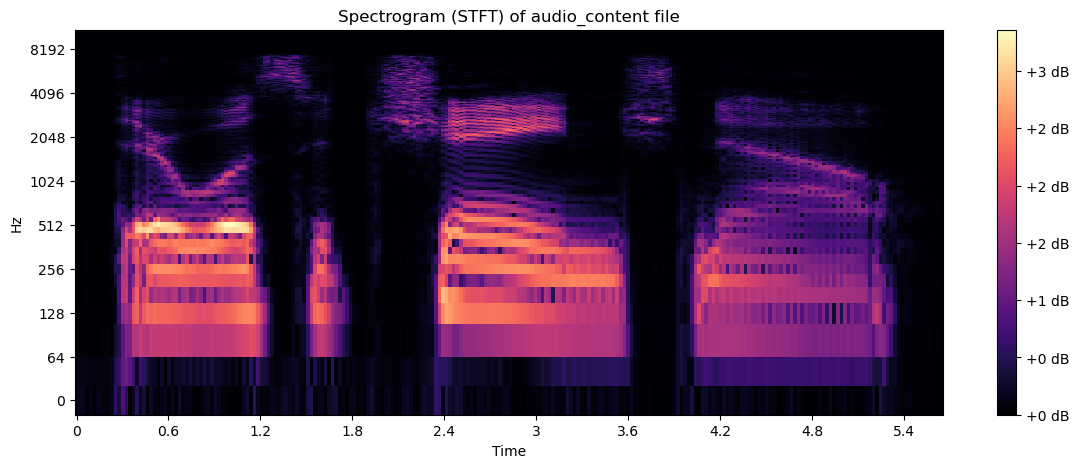

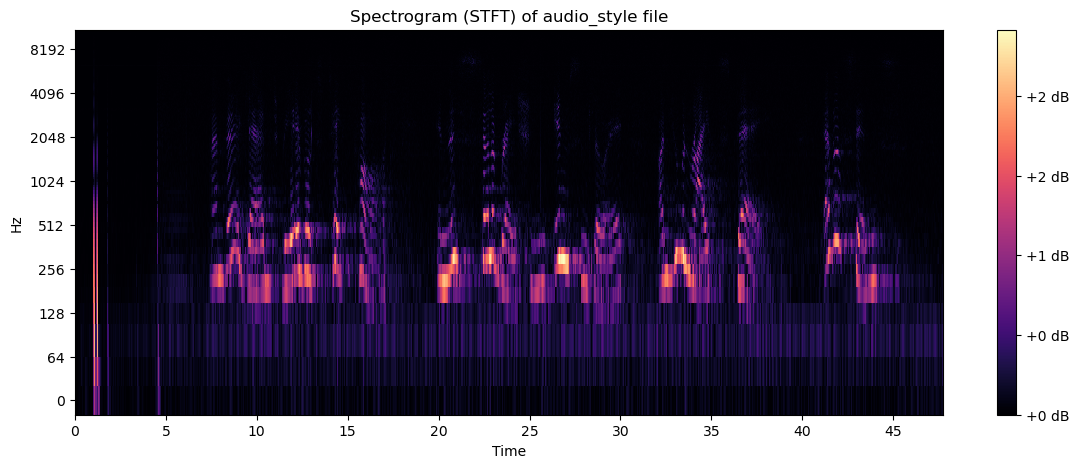

In [4]:
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
librosa.display.specshow(audio_content, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT) of audio_content file')
plt.show()


plt.figure(figsize=(14, 5))
librosa.display.specshow(audio_style, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT) of audio_style file')
plt.show()


## RandomCNN Model Explanation:

The `RandomCNN` class defines a simple 2D Convolutional Neural Network (CNN) for voice impersonation. Let's go through the layers and operations step by step:

1. **Input:**
   - The input to the model is a 4D tensor with shape `(batch_size, num_channels, height, width)`.
   - In this case, `batch_size` is 1 (as seen in the provided input), `num_channels` is 1 (grayscale), `height` is 257, and `width` is variable (244 in the given example).

2. **Convolutional Layer (conv1):**
   - The model starts with a 2D convolutional layer (`nn.Conv2d`) with a kernel size of (3, 1), producing `OUT_CHANNELS` number of output channels.
   - Leaky ReLU activation (`nn.LeakyReLU(0.2)`) is applied after the convolution operation.

3. **Constant Initialization:**
   - The weight and bias of the convolutional layer are set to specific constant values (`weight` is random, `bias` is zero).
   - This means the convolutional layer's parameters are fixed and won't be updated during training.

4. **Forward Pass:**
   - The `forward` method takes an input tensor (`x_delta`) and passes it through the convolutional layer followed by Leaky ReLU activation.
   - The output is the result of this operation.

In [5]:
audio_content_variable = Variable(audio_content_torch, requires_grad=False).float()
audio_style_variable = Variable(audio_style_torch, requires_grad=False).float()
audio_content = voice_impersonation_model(audio_content_variable)
audio_style = voice_impersonation_model(audio_style_variable)

learning_rate = 0.003
audio_G_var = Variable(
    torch.randn(audio_content_torch.shape) * 1e-3, requires_grad=True
)
opt = torch.optim.Adam([audio_G_var])

style_param = 1
content_param = 5e2

num_epochs = 3000
print_frequency = 50

## Training Process Explanation:

The provided code includes a training loop for the voice impersonation model. Here are the key steps:

1. **Input Spectrograms:**
   - Two input audio files (`content_file` and `style_file`) are converted to spectrograms (`audio_content_torch` and `audio_style_torch`).

2. **Model Initialization:**
   - An instance of the `RandomCNN` model is created and set to evaluation mode (`voice_impersonation_model.eval()`).

3. **Optimizer and Learning Rate:**
   - Adam optimizer is used with a learning rate of 0.003.

4. **Loss Parameters:**
   - `content_param` and `style_param` are weights used to balance the content and style losses during training.

5. **Training Loop:**
   - The model is trained for a specified number of epochs (3000 in this case).
   - The training loop consists of updating the model's parameters to minimize the combined content and style losses.

6. **Loss Calculation:**
   - Content loss (`compute_content_loss`) measures the difference between the generated audio and the content audio.
   - Style loss (`compute_layer_style_loss`) measures the difference in style between the generated audio and the style audio.
   - The total loss is a combination of content and style losses.

7. **Backpropagation and Optimization:**
   - The gradients are calculated with respect to the loss, and the optimizer (`Adam`) is used to update the model's parameters.

8. **Print Information:**
   - The training progress is printed every 50 epochs, showing the epoch number, content loss, style loss, and total loss.

9. **Output Audio Generation:**
   - After training, the generated audio spectrogram (`audio_G_var`) is converted back to a waveform and saved as a sound file (`output_audio_name`).

In [6]:
for epoch in range(1, num_epochs + 1):
    opt.zero_grad()
    audio_G = voice_impersonation_model(audio_G_var)

    content_loss = content_param * compute_content_loss(audio_content, audio_G)
    style_loss = style_param * compute_layer_style_loss(audio_style, audio_G)
    loss = content_loss + style_loss
    loss.backward()
    opt.step()

    if epoch % print_frequency == 0:
        print("epoch: " + str(epoch))
        print("content loss: " + str(content_loss.item()))
        print("style loss: " + str(style_loss.item()))
        print("loss: " + str(loss.item()))

epoch: 50
content loss: 35.85826110839844
style loss: 326.4397277832031
loss: 362.2979736328125
epoch: 100
content loss: 32.530311584472656
style loss: 313.6589050292969
loss: 346.189208984375
epoch: 150
content loss: 29.66212272644043
style loss: 294.53692626953125
loss: 324.19903564453125
epoch: 200
content loss: 27.373268127441406
style loss: 272.7935485839844
loss: 300.16680908203125
epoch: 250
content loss: 25.50568199157715
style loss: 250.86184692382812
loss: 276.3675231933594
epoch: 300
content loss: 23.891162872314453
style loss: 229.4459686279297
loss: 253.33712768554688
epoch: 350
content loss: 22.455347061157227
style loss: 208.6265869140625
loss: 231.08193969726562
epoch: 400
content loss: 21.190019607543945
style loss: 188.49758911132812
loss: 209.68760681152344
epoch: 450
content loss: 20.091962814331055
style loss: 169.2670135498047
loss: 189.35897827148438
epoch: 500
content loss: 19.150136947631836
style loss: 151.15745544433594
loss: 170.30758666992188
epoch: 550
con

## Explanation of `spectrum2wav` Function:

The `spectrum2wav` function takes a magnitude spectrogram (`spectrum`), sampling rate (`sr`), and an output file path (`outfile`) as input and converts it back to a waveform, saving the resulting audio in a sound file.

1. **Magnitude to Amplitude Conversion:**
   - `a = np.exp(spectrum) - 1`: Converts the magnitude spectrogram to amplitude by applying the inverse of the logarithmic transformation used during the creation of the spectrogram.

2. **Random Phase Initialization:**
   - `p = 2 * np.pi * np.random.random_sample(spectrum.shape) - np.pi`: Initializes a random phase vector within the range of -π to π.

3. **Inverse Short-Time Fourier Transform (iSTFT):**
   - The function enters a loop iterating 50 times.
   - `S = a * np.exp(1j * p)`: Combines the amplitude (`a`) with the randomly initialized phase (`p`) to create a complex spectrogram.
   - `x = librosa.istft(S)`: Performs the inverse Short-Time Fourier Transform to convert the complex spectrogram back to a time-domain signal.

4. **Update Phase for Next Iteration:**
   - `p = np.angle(librosa.stft(x, n_fft=N_FFT))`: Updates the phase for the next iteration based on the current reconstructed signal.

5. **Saving the Output Audio:**
   - The resulting time-domain signal (`x`) is saved as a sound file using the `sf.write` function.

In [7]:
import soundfile as sf

gen_spectrum = audio_G_var.cpu().data.numpy().squeeze()
output_audio_name = "Eleanor_saying_there_was_a_change_now.wav"
spectrum2wav(gen_spectrum, sampling_rate, output_audio_name)

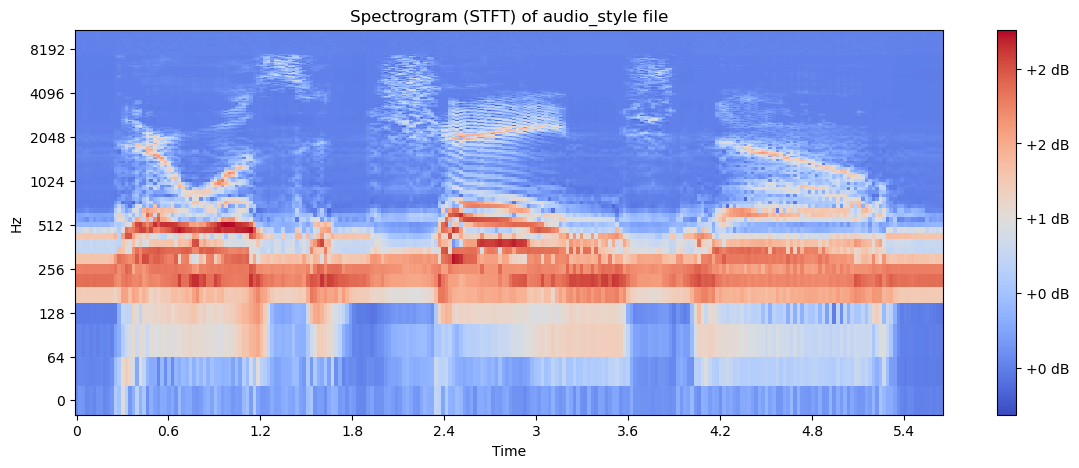

In [8]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(gen_spectrum, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT) of audio_style file')
plt.show()